### A Machine learning approach to identify spurious GPS readings



In [4]:
%run "../common.ipynb"

fileName="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=WITH rows AS (SELECT *,ROW_NUMBER() OVER (ORDER BY mobile_id, id DESC) AS rn FROM loc WHERE (record_type <> 'active' OR record_type IS NULL)) SELECT * FROM rows loc1 WHERE (loc1.rn,loc1.mobile_id)  IN ((SELECT loc2.rn, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-1, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B1, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-2, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B2, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn-3, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) UNION (SELECT loc2.rn%2B3, loc2.mobile_id FROM rows loc2 WHERE loc2.is_valid != 1) )&type=html";
fileName = fileName.replace(' ', '%20')
dfOriginal = LoadDataSet(fileName, columns=None, checkForDateTime=False);


In [5]:
from datetime import datetime,timedelta
# Prepare dataset
#
# 1. Drop columns we don't need
# 2. Convert column datatypes as needed; to string, datetime, numbers as needed
# 3. Add Calculated Columns
# 4. Filter out rows and reindex the dataframe
# 5. Display the resulting dataframe
# 6. Show some descriptive statistics

#=====
#1. "ProcessedDateId" column is Intentionally misspelled to show it goes undetected if not careful

columns = '''
id, 
stored_at, measured_at, is_valid, api_key, version, record_type, session_num, 
mobile_id, user_id, caller_ip, 
lat, lon, accuracy, speed, bearing, alt, device_temp, device_pressure, device_humidity, device_light, medication, 
weather_time, temperature_min, temperature_max, humidity, no2, pressure, wind, clouds_sky, notes, attr, the_geom, 
location, activity, battery_level, rn"
'''
toDrop= [k.strip() for k in '''id, api_key, version,  session_num, 
mobile_id, 
user_id, 
caller_ip, device_temp, device_pressure, device_humidity, device_light, medication, weather_time, 
temperature_min, temperature_max, humidity, no2, pressure, wind, clouds_sky, notes, attr, 
the_geom,weatherchecked,

'''.split(",")]
dfL = dfOriginal.drop(toDrop, axis=1, errors="ignore")

##1a -> Set the Prediction column
##   -> Set class names if you know it or make it None
predictColumn = "is_valid"
class_names = ["Inalid", "Valid"]

##2. Some wrong dates causing error here - so lets treat this as str
dfL[predictColumn] = dfL[predictColumn].astype(str)    # Treat this columns as string
#dfL[u'ProcessedDateId']   = dfL[u'ProcessedDateId'].astype(str)      # Treat this columns as string (intentionally included)


##3. Calculated columns
#dfL[u'DBKLag'] = dfL[u'DBKLag']/60                                   # lets divide this by 60 
#dfL[u'DBKLag'] = dfL.DBKLag.apply(abs)                               # Convert to absolute value 

secfromprev = []
sectonext = []
distfromprev = []
disttonext = []
spdfromprev = []
spdtonext = []
angle = []

for k in range(len(dfL[predictColumn])):
    if k == 0 or k == len(dfL[predictColumn])-1:
        secfromprev.append(None)
        sectonext.append(None)
        distfromprev.append(None)
        disttonext.append(None)
        spdfromprev.append(None)
        spdtonext.append(None)
        angle.append(None)
    else:
        curdatetime = datetime.strptime(dfL['measured_at'][k].split('.')[0],'%Y-%m-%d %H:%M:%S')
        prevdatetime = datetime.strptime(dfL['measured_at'][k+1].split('.')[0],'%Y-%m-%d %H:%M:%S')
        nextdatetime = datetime.strptime(dfL['measured_at'][k-1].split('.')[0],'%Y-%m-%d %H:%M:%S')
        
        #seconds from previous
        secfromprev.append((curdatetime - prevdatetime).seconds)
        
        #seconds to next
        sectonext.append((nextdatetime-curdatetime).seconds)
        
        
        curlat = dfL['lat'][k]
        curlon = dfL['lon'][k]
        
        nextlat = dfL['lat'][k-1]
        nextlon = dfL['lon'][k-1]
        
        prevlat = dfL['lat'][k+1]
        prevlon = dfL['lon'][k+1]
        
        #miles to next
        disttonext.append(math.sqrt(69.1*(curlat-nextlat)*69.1*(curlat-nextlat)+(69.1*(curlon - nextlon)*cos(nextlat/57.3))*(69.1*(curlon - nextlon)*cos(nextlat/57.3))))
        #print(disttonext[k])
        
        #miles from prev
        distfromprev.append(math.sqrt(69.1*(curlat-prevlat)*69.1*(curlat-prevlat)+(69.1*(curlon - prevlon)*cos(prevlat/57.3))*(69.1*(curlon - prevlon)*cos(prevlat/57.3))))
        #print(distfromprev[k])
        
        #Speed in MPH to next
        if sectonext[k] != 0:
            spdtonext.append(disttonext[k]/(sectonext[k]/3600))
        else:
            spdtonext.append(None)
        #print(spdtonext[k])
        
        #Speed in MPH from prev
        if secfromprev[k] != 0:
            spdfromprev.append(distfromprev[k]/(secfromprev[k]/3600))
        else:
            spdfromprev.append(None)
        #print(spdfromprev[k])
        
        #Angle in degrees between previous point, next point, and current point
        if distfromprev[k]*disttonext[k] != 0:
            distancebetweennextandprev = math.sqrt(69.1*(prevlat-nextlat)*69.1*(prevlat-nextlat)+(69.1*(prevlon - nextlon)*cos(nextlat/57.3))*(69.1*(prevlon - nextlon)*cos(nextlat/57.3)))
            lawofcos = (math.pow(distancebetweennextandprev,2) - math.pow(distfromprev[k],2) - math.pow(disttonext[k],2))/(-2*distfromprev[k]*disttonext[k])
            if lawofcos < -1:
                lawofcos = -1
            if lawofcos > 1:
                lawofcos = 1
            angle.append((180/math.pi)*math.acos(lawofcos))
        else:
            angle.append(None)
        #print(angle[k])
        
dfL['secfromprev'] = secfromprev
dfL['sectonext'] = sectonext
dfL['distfromprev'] = distfromprev
dfL['disttonext'] = disttonext
dfL['spdfromprev'] = spdfromprev
dfL['spdtonex'] = spdtonext
dfL['angle'] = angle


#print(dfL['rn'][dfL['is_valid']=='2'])

        
##4. Filter rows
n1 = dfL.shape[0]
#dfL = dfL[dfL.DBKLag > 1]                                            # Lets take only those that have a value > 0 
#
## Here are other common filtering you may use:
# dfL = dfL[dfL['OEMModel'] == "Surface Pro 4"]
# dfL = dfL[dfL.OSVersionFull.str.contains("th1") | dfL.OSVersionFull.str.contains("th2")]
# dfL = dfL[dfL.is_valid == '2'-1 | dfL.is_valid == '2' | dfL.is_valid == '2'+1]
#print(dfL[dfL.is_valid == '2'-1 | dfL.is_valid == '2' | dfL.is_valid == '2'+1])
#print(dfL.is_valid[1:] == '2' dfL.is_valid == '2' or dfL.is_valid[:1] == '2')
goodrows = (dfL.is_valid == '2') | (dfL.is_valid.shift(1) == '2') | (dfL.is_valid.shift(-1) == '2') | (dfL.is_valid.shift(2) == '2') | (dfL.is_valid.shift(-2) == '2') 
#print(dfL[goodrows])
dfL = dfL[goodrows]

#Sorted version for mapping
dfL2 = dfL

n2 = dfL.shape[0]
print ("Filtering: Number of rows Before {} and After {}".format(n1,n2));

#4a. You may reshuffle the rows if needed to make sure they are not in any particular order
dfL = dfL.sample(frac=1).reset_index(drop=True)

#4b. 
# Once you filter, it is a good idea to reindex such that 0th row matches to 0th row in the resulting dataframe
# To see what happens if you didn't to reindex, comment out the following code and notice index 1 and 3 are visibly missing 

dfL = dfL.reset_index(drop=True) 

#5.
displayDFs(dfL, showIcons=True, showStats=True, maxrows = 4) 

# You can see the entire dataframe by using the following
# HTML(dfL.to_html())

Filtering: Number of rows Before 188 and After 136


count,136,136,136,136,136.000,136.000,136.000,126.000,126.000,126.000,0.000,136,0.000,136,136,136.000,136.000,136.000,136.000,136.000,129.000,129.000,123.000
unique,136,130,2,6,-,-,-,-,-,-,0.000,1,0.000,1,1,-,-,-,-,-,-,-,-
top,2016-04-20 02:22:32.26433,2016-03-09 00:27:46.0,1,gps,-,-,-,-,-,-,-,null,-,null,null,-,-,-,-,-,-,-,-
freq,1,2,105,86,-,-,-,-,-,-,-,136,-,136,136,-,-,-,-,-,-,-,-
mean,-,-,-,-,44.921,-99.116,256.789,1.095,26.357,63.992,-,-,-,-,-,13341.265,2176.404,1730.529,55.335,70.591,132.017,108.284,57.191
std,-,-,-,-,5.712,59.345,450.761,4.393,71.000,279.752,-,-,-,-,-,4440.999,9308.398,7686.197,635.913,814.516,628.453,527.317,56.430
min,-,-,-,-,24.186,-122.322,0.000,0.000,0.000,-10.000,-,-,-,-,-,1616.000,0.000,0.000,0.000,0.000,0.001,0.001,0.000
25%,-,-,-,-,44.881,-122.143,21.447,0.000,0.000,0.000,-,-,-,-,-,11764.750,25.750,25.750,0.031,0.033,1.406,1.406,4.438
50%,-,-,-,-,47.643,-122.137,48.787,0.000,0.000,0.000,-,-,-,-,-,13177.500,60.500,61.000,0.121,0.122,7.049,7.410,41.261
75%,-,-,-,-,47.645,-104.904,100.000,0.000,0.000,0.000,-,-,-,-,-,15722.250,265.000,247.250,0.324,0.353,23.505,25.483,105.571
max,-,-,-,-,47.654,127.050,2805.000,28.750,357.000,1884.000,-,-,-,-,-,22750.000,63561.000,62894.000,7416.665,9499.477,5219.790,5232.399,180.000


### Descriptive Statistics

In [14]:
#Wade can you find a way to plot the points on a map here!

# Given three consecutive readings from a GPS system (p1, p2, p3), is it possible to detect if p2 is invalid?
# or Give a set of points p1 .. pn, detect all invalid readings!

import folium



midlat = mean(dfL2['lat'])
midlon = mean(dfL2['lon'])



dfL2.reset_index(drop=True,inplace=True)

#pd.set_option('display.max_rows', len(dfL2['is_valid']))
#print(dfL2)
#pd.reset_option('display.max_rows')


map1 = folium.Map(location=(47.643, -122.129) , zoom_start=14, width=640, height=500)

for k in range(len(dfL2['is_valid'])):
    if dfL2['is_valid'][k] == '1':
        #Valid Points Blue
        fcolor = '#0000FF'
    else:
        #Invalid Points Yellow
        fcolor = '#FFFF00'
    
    #map1.circle_marker(location=[dfL['lat'][k], dfL['lon'][k]], radius=500, line_color='#000000',fill_color=fcolor)
    folium.CircleMarker([dfL2['lat'][k], dfL2['lon'][k]],
                    radius=7,
                    color=fcolor,
                    fill_color=fcolor,
                   ).add_to(map1)
    if k != len(dfL2[predictColumn])-1 and (k+1)%5 != 0:
        map1.line([[dfL2['lat'][k],dfL2['lon'][k]],[dfL2['lat'][k+1],dfL2['lon'][k+1]]], line_color='#000000', line_weight=1)
        
display(map1)  


/Users/snarayan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:39: FutureWarning: line is deprecated. Use add_children(PolyLine) instead


Dropping in prepareDF -  Index(['stored_at', 'measured_at'], dtype='object')


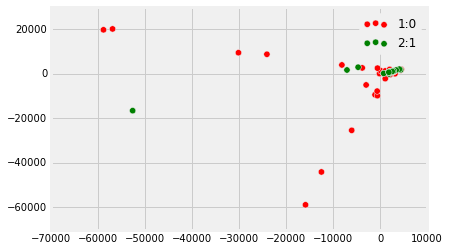

In [7]:
dfPCA=PCAPlot(dfL, predictColumn)

## Predictions

In [98]:
# Lets convert the columns to numeric 
# Please see Prepare in Features.py 

df =  prepareDF(dfL, makeCopy=True)

# Review the resulting final data set;
#df = df.sample(frac=1).reset_index(drop=True)
display(dfL.head(), "==>" ,df.head() )

Dropping in prepareDF -  Index(['stored_at', 'measured_at'], dtype='object')


,stored_at,measured_at,is_valid,record_type,lat,lon,accuracy,speed,bearing,alt,location,activity,battery_level,rn,secfromprev,sectonext,distfromprev,disttonext,spdfromprev,spdtonex,angle
0,2016-04-11 19:41:57.551713,2016-04-11 18:44:52.0,1,passive,47.649,-122.144,46.000,12.000,357.000,163.000,None,null,None,12405,8.000,22.000,0.165,0.165,74.139,26.960,0.000
1,2016-04-13 01:40:24.602689,2016-04-12 23:58:23.0,1,passive,47.647,-122.134,800.000,0.000,0.000,0.000,None,null,None,12212,60.000,21.000,0.298,0.182,17.900,31.280,33.220
2,2016-03-30 00:23:28.100115,2016-03-30 00:06:41.0,1,gps,47.652,-122.145,12.000,0.250,221.000,100.000,None,null,None,14218,50.000,65.000,0.020,0.118,1.406,6.532,148.838
3,2016-03-09 01:25:03.421149,2016-03-09 00:26:10.0,1,gps,47.620,-122.192,24.000,0.000,0.000,0.000,None,null,None,16389,790.000,0.000,0.224,0.000,1.019,nan,nan
4,2016-04-27 02:34:43.988347,2016-04-25 13:30:01.0,1,gps,39.854,-104.676,31.220,0.000,0.000,0.000,None,null,None,10754,783.000,46.000,0.024,0.613,0.109,47.992,157.916


'==>'

,is_valid,record_type,lat,lon,accuracy,speed,bearing,alt,location,activity,battery_level,rn,secfromprev,sectonext,distfromprev,disttonext,spdfromprev,spdtonex,angle
0,0,5,47.649,-122.144,46.000,12.000,357.000,163.000,0,0,0,12405,8.000,22.000,0.165,0.165,74.139,26.960,0.000
1,0,5,47.647,-122.134,800.000,0.000,0.000,0.000,0,0,0,12212,60.000,21.000,0.298,0.182,17.900,31.280,33.220
2,0,3,47.652,-122.145,12.000,0.250,221.000,100.000,0,0,0,14218,50.000,65.000,0.020,0.118,1.406,6.532,148.838
3,0,3,47.620,-122.192,24.000,0.000,0.000,0.000,0,0,0,16389,790.000,0.000,0.224,0.000,1.019,0.000,0.000
4,0,3,39.854,-104.676,31.220,0.000,0.000,0.000,0,0,0,10754,783.000,46.000,0.024,0.613,0.109,47.992,157.916


Feature space holds 136 observations and 18 features
Unique target labels: [0 1]
* 0* 1* 2* 3* 4*
   DecisionTree Gini accuracy: 0.801471 
             precision    recall  f1-score   support

          0       0.82      0.94      0.88       105
          1       0.62      0.32      0.43        31

avg / total       0.78      0.80      0.78       136


* 0* 1* 2* 3* 4*
   DecisionTree Entr accuracy: 0.786765 
             precision    recall  f1-score   support

          0       0.84      0.90      0.87       105
          1       0.54      0.42      0.47        31

avg / total       0.77      0.79      0.78       136


* 0* 1* 2* 3* 4*
                 SVM accuracy: 0.786765 
             precision    recall  f1-score   support

          0       0.80      0.96      0.87       105
          1       0.60      0.19      0.29        31

avg / total       0.76      0.79      0.74       136


* 0* 1* 2* 3* 4*
                K-NN accuracy: 0.830882 
             precision    recall  f1-sc

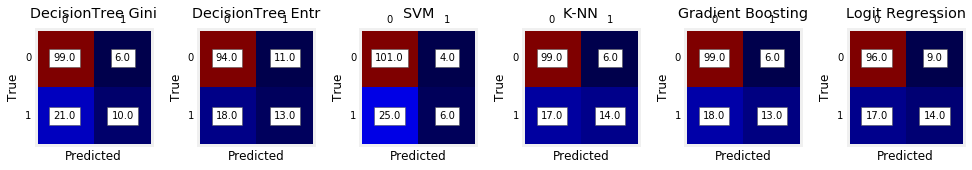

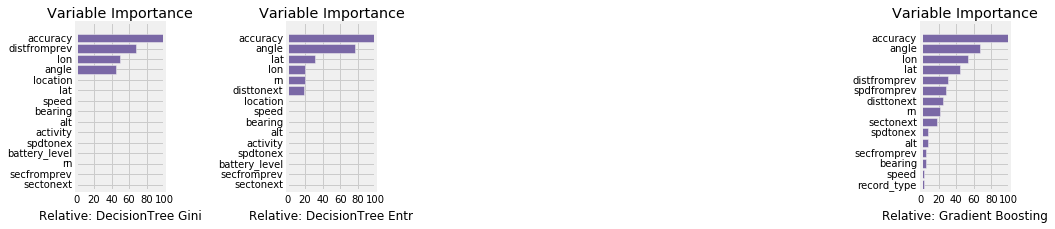

Wall time: 1.57 s


In [99]:
%%time
cls = [# Comment/uncomment out any classfiers according to your need 
       # DO NOT CHANGE
        "DecisionTree Gini" , tree.DecisionTreeClassifier(max_depth=4, criterion="gini"),
        "DecisionTree Entr" , tree.DecisionTreeClassifier(max_depth=4, criterion="entropy"), 
        "SVM"               , sklearn.svm.SVC(), 
        #"Random Forest"     , sklearn.ensemble.RandomForestClassifier(),
        "K-NN"              , sklearn.neighbors.KNeighborsClassifier(),
        "Gradient Boosting" , sklearn.ensemble.RandomForestClassifier(),
        "Logit Regression"  , sklearn.linear_model.LogisticRegression()
];

y = df[predictColumn]
X = df.drop(predictColumn, axis=1)
(X1,y1,ra,cls) = Classify(X,y, True, drawConfusionMatrix=True, classifiers=cls, scale=True)


In [100]:
#get_ipython().reset()
decisionTrees = []

for k in range( int (len(cls)/2)) :
    d = cls[k*2+1];
    if (str(type(d)).find('DecisionTreeClassifier') > 0):
        decisionTrees.append(cls[k*2])
        decisionTrees.append(cls[k*2+1])

#d = DrawDecisionTree(X,y, decisionTrees, class_names);

In [ ]:
#
# Now we need to get the 
# Given three points, distance, angle, time difference, number of time that loc was marked invalid
#

1
2 lat-lon
1
==>
2 speed (1-2); time1 -2 , distance 1-2, angle 1-2-1, # of times 2 is Invalid 

1
1 speed (1-1); time1 -1 , distance 1-1, angle 1-1-1, # of times 1 was read
1
